In [49]:
import os
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import glob
import re
from scipy.special import gamma
import matplotlib.pyplot as plt
from collections import defaultdict


spe_files = glob.glob('PMT7_SPE_CLEAN/*.csv')

print("SPE files found:")
for f in spe_files:
    print(" ", f)

SPE files found:
  PMT7_SPE_CLEAN/030226_spe_1800_500_2_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1750_500_3_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1900_500_1_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1900_500_2_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1800_500_1_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1950_500_2_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1850_500_1_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1850_500_2_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1950_500_1_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_2000_500_3_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1850_500_3_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_2000_500_2_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_2000_500_1_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_1750_500_1_on_ch1_processed_cleaned.csv
  PMT7_SPE_CLEAN/030226_spe_190

In [50]:
def get_voltage(filepath):
    filename = os.path.basename(filepath)
    match = re.search(r'_(\d{3,4})_', filename)
    return int(match.group(1))


def collect_charge_by_voltage(file_list):
    """
    Groups all integral_pC values by voltage and concatenates them.
    Returns dict: voltage -> np.array(all charges)
    """
    voltage_dict = defaultdict(list)

    for file in file_list:
        voltage = get_voltage(file)
        df = pd.read_csv(file)
        charge = df['integral_pC'].values
        voltage_dict[voltage].append(charge)

    # concatenate per voltage
    for v in voltage_dict:
        voltage_dict[v] = np.concatenate(voltage_dict[v])

    return voltage_dict

In [51]:
def polya_dist(positive_charge_data, A, nbar, theta):
    # A = amplitude / normalisation
    polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))
    return polya_PMF


def fit_polya_and_get_peak(all_integrals_picocharge, bin_cut, Delta_x=0.1, filename=None):

    # keep only positive charges
    positive_charge_data = all_integrals_picocharge[all_integrals_picocharge > 0]

    # histogram
    int_number_of_bins = int((np.max(positive_charge_data) - np.min(positive_charge_data)) / Delta_x)
    n, bins = np.histogram(positive_charge_data, bins=int_number_of_bins)
    bin_centers = 0.5 * (bins[1:] + bins[:-1])

    # apply fit cut
    mask = bin_centers >= bin_cut
    n_fit = n[mask]
    bin_centers_fit = bin_centers[mask]

    positive_charge_data_cut = positive_charge_data[positive_charge_data >= bin_cut]

    # initial guesses
    initial_nbar = np.mean(positive_charge_data_cut)
    initial_var = np.var(positive_charge_data_cut)
    N_events = len(positive_charge_data)

    initial_A = N_events * Delta_x
    initial_theta = np.abs((initial_nbar**2 / initial_var) - 1)

    p0 = [initial_A, initial_nbar, initial_theta]

    sigma=np.sqrt(n_fit)
    print(np.sqrt(n_fit))
    sigma[sigma==0.0] = 1

    # fit
    popt, pcov = curve_fit(
        polya_dist,
        bin_centers_fit,
        n_fit,
        p0=p0,
        sigma=sigma,
        absolute_sigma=True,
        maxfev=10000
    )

    A_fit, nbar_fit, theta_fit = popt
    err_A = np.sqrt(pcov[0, 0])
    err_nbar = np.sqrt(pcov[1, 1])
    err_theta = np.sqrt(pcov[2, 2])

    # peak position
    peak = (theta_fit / (theta_fit + 1)) * nbar_fit

    dpeak_dnbar = theta_fit / (theta_fit + 1)
    dpeak_dtheta = nbar_fit / (theta_fit + 1)**2

    peak_err = np.sqrt(
        (dpeak_dnbar * err_nbar)**2 +
        (dpeak_dtheta * err_theta)**2 +
        2*dpeak_dnbar*dpeak_dtheta*pcov[1,2]
    )

    # chi^2
    model_fit = polya_dist(bin_centers_fit, *popt)
    valid = n_fit > 0
    chi2 = np.sum((n_fit[valid] - model_fit[valid])**2 / n_fit[valid])
    ndof = np.sum(valid) - len(popt)
    chi2_red = chi2 / ndof

    if peak_err == np.inf:
        peak_err=-100
    # plot
    plt.figure(figsize=(6,6))
    plt.bar(bin_centers, n, width=Delta_x, alpha=0.6, label='Data')

    x_fit = np.linspace(bin_cut, np.max(bin_centers), 600)
    plt.plot(x_fit, polya_dist(x_fit, *popt), 'r-', lw=2,
             label=rf'Polya fit, $\chi^2_\nu={chi2_red:.2f}$')

    plt.axvline(peak, color='k', linestyle='--',
                label=rf'Peak = ${peak:.3f}\pm{peak_err:.3f}$ pC')

    plt.xlim(0, np.max(bin_centers))
    plt.xlabel('Charge (pC)')
    plt.ylabel('Counts')

    if filename is not None:
        plt.title(filename)
    else:
        plt.title('Polya fit to pulse integral histogram')

    plt.legend()
    plt.tight_layout()
    plt.show()

    return peak, peak_err

[2.         2.82842712 1.41421356 2.64575131 1.41421356 2.23606798
 3.16227766 2.         3.74165739 3.16227766 2.82842712 3.60555128
 2.64575131 3.         2.82842712 4.         3.16227766 3.74165739
 3.74165739 3.16227766 3.         2.44948974 3.16227766 3.31662479
 2.64575131 2.64575131 2.64575131 3.16227766 3.60555128 3.16227766
 3.31662479 3.60555128 3.         3.         3.16227766 2.82842712
 2.23606798 2.44948974 2.82842712 2.23606798 1.         2.23606798
 1.73205081 1.73205081 2.         3.         2.23606798 2.82842712
 1.         1.         1.41421356 1.41421356 2.         1.41421356
 2.         1.73205081 1.73205081 2.         2.23606798 1.
 2.         0.         1.         1.         1.41421356 1.41421356
 1.73205081 1.         1.73205081 1.         2.         1.
 1.41421356 1.         1.         1.         1.         0.
 0.         1.         1.41421356 0.         0.         0.
 1.         0.         0.         0.         0.         1.
 0.         0.         0.         1

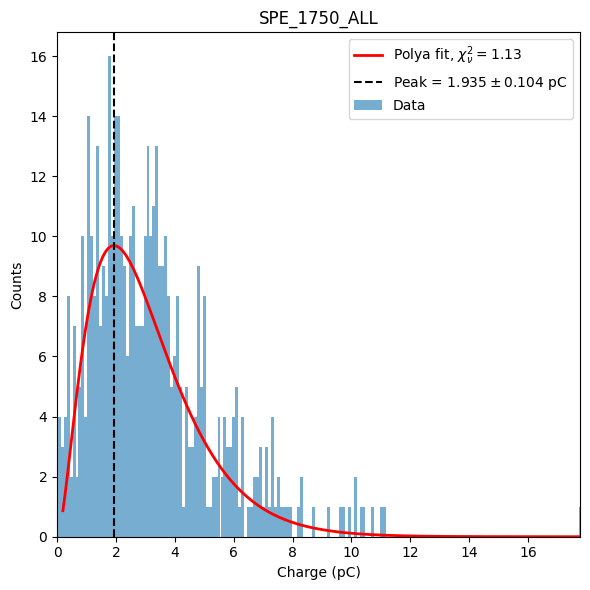

[4.47213595 5.38516481 5.09901951 5.47722558 5.56776436 5.65685425
 5.38516481 4.89897949 5.09901951 5.47722558 6.164414   5.91607978
 5.29150262 5.19615242 6.         4.24264069 5.09901951 6.08276253
 5.29150262 4.47213595 5.91607978 3.31662479 4.35889894 3.16227766
 3.31662479 2.64575131 3.74165739 3.16227766 3.46410162 2.
 3.46410162 2.44948974 2.64575131 3.31662479 2.44948974 2.82842712
 1.         0.         1.73205081 2.23606798 1.41421356 2.
 1.         2.23606798 1.73205081 1.41421356 1.73205081 0.
 1.73205081 2.23606798 1.         1.         1.         1.41421356
 1.         0.         1.         1.73205081 1.         0.
 1.41421356 1.41421356 1.         1.41421356 0.         1.41421356
 0.         1.         0.         0.         0.         1.41421356
 0.         1.73205081 1.         0.         0.         0.
 1.41421356 1.41421356 1.41421356 0.         0.         0.
 0.         0.         0.         1.         0.         1.
 1.41421356 0.         0.         0.         0.    

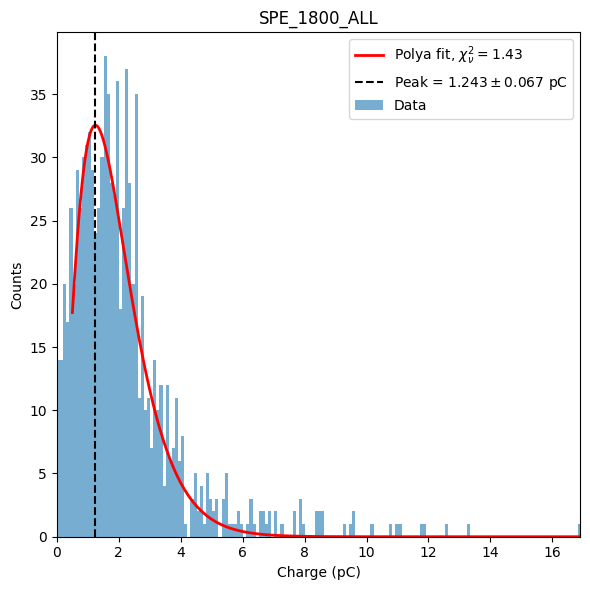

[6.164414   6.78232998 6.08276253 6.78232998 6.78232998 6.92820323
 7.         5.74456265 6.63324958 6.40312424 7.87400787 6.4807407
 7.14142843 5.65685425 6.63324958 6.08276253 5.19615242 4.58257569
 6.08276253 5.19615242 4.69041576 4.69041576 4.24264069 4.24264069
 3.46410162 3.60555128 4.89897949 3.87298335 2.64575131 3.16227766
 2.44948974 3.         2.         2.23606798 3.16227766 2.23606798
 2.44948974 2.23606798 2.         1.73205081 2.23606798 1.
 1.73205081 1.41421356 1.73205081 1.         1.41421356 1.
 1.41421356 1.         1.73205081 1.41421356 0.         1.73205081
 1.         1.         0.         2.         1.41421356 0.
 1.         1.41421356 1.         1.         1.         1.41421356
 0.         0.         1.41421356 0.         1.         1.
 0.         1.         0.         1.         1.         0.
 1.         1.41421356 0.         1.73205081 1.         0.
 1.         0.         1.         1.         0.         0.
 0.         1.41421356 0.         1.         1.     

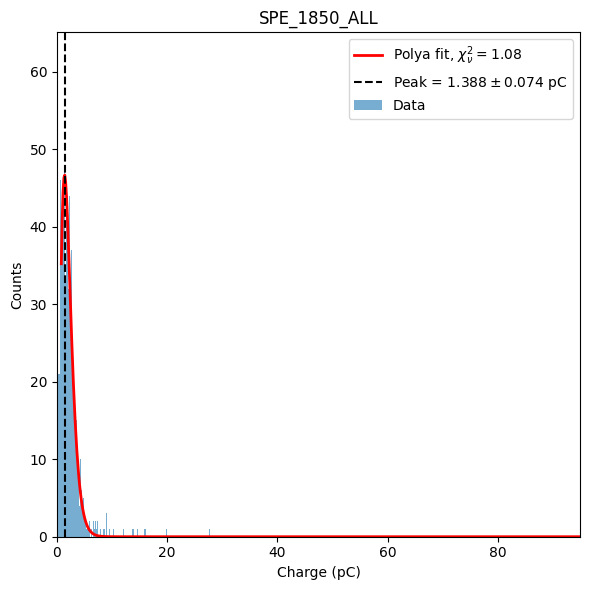

[5.47722558 5.09901951 6.244998   6.164414   6.40312424 6.70820393
 6.78232998 6.55743852 6.40312424 6.08276253 7.28010989 6.
 6.08276253 5.47722558 6.63324958 5.47722558 5.19615242 4.89897949
 5.74456265 5.09901951 4.58257569 5.         3.87298335 4.58257569
 3.60555128 5.09901951 4.         4.         2.         3.46410162
 4.12310563 2.         2.         1.73205081 2.44948974 2.
 2.44948974 1.73205081 2.64575131 1.         1.73205081 0.
 1.73205081 1.41421356 1.         1.41421356 0.         0.
 2.         0.         1.         1.41421356 0.         0.
 1.41421356 2.         1.41421356 0.         1.41421356 1.
 0.         1.         0.         1.41421356 1.         1.
 1.         0.         1.         1.         0.         0.
 1.         1.73205081 1.         0.         1.         1.41421356
 1.         1.         0.         1.         2.         0.
 1.         1.73205081 1.         1.         1.         0.
 0.         0.         1.         0.         1.         1.
 1.73205081 0.  

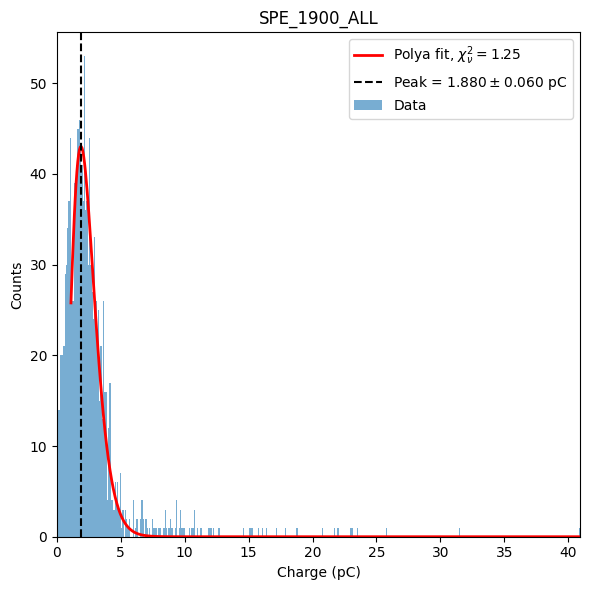

[4.12310563 4.89897949 5.56776436 4.79583152 5.38516481 5.38516481
 5.38516481 4.79583152 5.47722558 4.47213595 4.79583152 5.09901951
 4.79583152 4.12310563 3.87298335 4.79583152 4.47213595 4.69041576
 4.35889894 3.16227766 4.58257569 3.16227766 4.24264069 3.74165739
 3.46410162 3.16227766 3.         3.16227766 2.64575131 2.82842712
 2.         2.82842712 2.23606798 2.         1.41421356 2.
 1.41421356 2.44948974 2.         1.41421356 1.41421356 1.73205081
 1.         1.73205081 1.         2.23606798 1.         0.
 0.         1.         0.         0.         1.         1.
 1.41421356 0.         0.         0.         0.         0.
 0.         1.         0.         0.         1.         1.
 1.         0.         0.         1.         1.41421356 1.41421356
 0.         0.         1.         1.41421356 0.         0.
 0.         0.         0.         1.         1.         1.
 1.         0.         0.         0.         0.         0.
 1.         1.         0.         0.         0.         1.


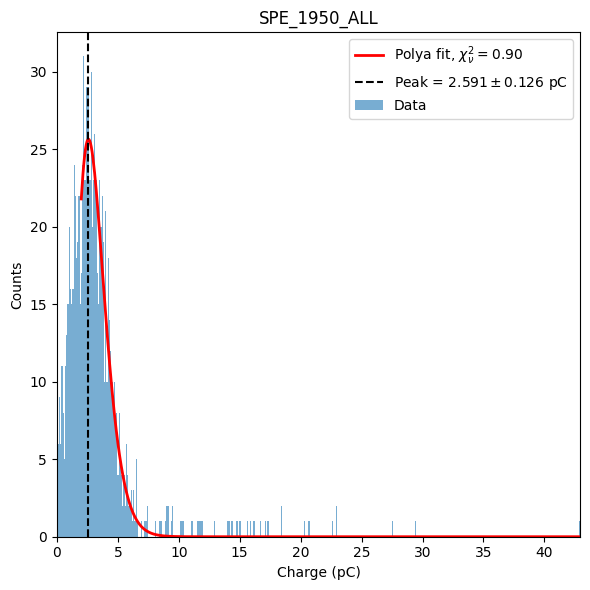

[5.83095189 5.38516481 4.89897949 5.65685425 4.69041576 5.29150262
 5.38516481 5.65685425 4.89897949 5.56776436 5.19615242 5.19615242
 5.38516481 5.74456265 5.38516481 6.40312424 5.09901951 5.09901951
 5.09901951 5.19615242 5.47722558 4.69041576 5.38516481 4.24264069
 3.60555128 4.58257569 3.74165739 2.82842712 2.64575131 3.74165739
 3.46410162 3.74165739 3.16227766 3.         2.23606798 3.31662479
 2.23606798 1.41421356 3.31662479 3.16227766 2.44948974 2.82842712
 2.44948974 1.         1.41421356 1.         1.73205081 2.23606798
 1.41421356 1.41421356 1.73205081 2.         1.41421356 1.41421356
 1.         1.41421356 1.73205081 0.         1.         1.
 1.41421356 0.         1.41421356 1.         1.         1.41421356
 0.         0.         0.         1.         0.         1.41421356
 1.41421356 0.         0.         1.         1.         0.
 0.         1.         0.         1.         1.         0.
 0.         0.         1.         0.         1.         0.
 0.         1.         0.  

/var/folders/54/shy8r4g15d33hf9px0m5hytc0000gn/T/ipykernel_68354/575213231.py:3: RuntimeWarning: invalid value encountered in power
  polya_PMF = A*((theta + 1)**(theta + 1))*(1/gamma(theta + 1))*((positive_charge_data/nbar)**theta)*np.exp(-(theta + 1)*(positive_charge_data/nbar))


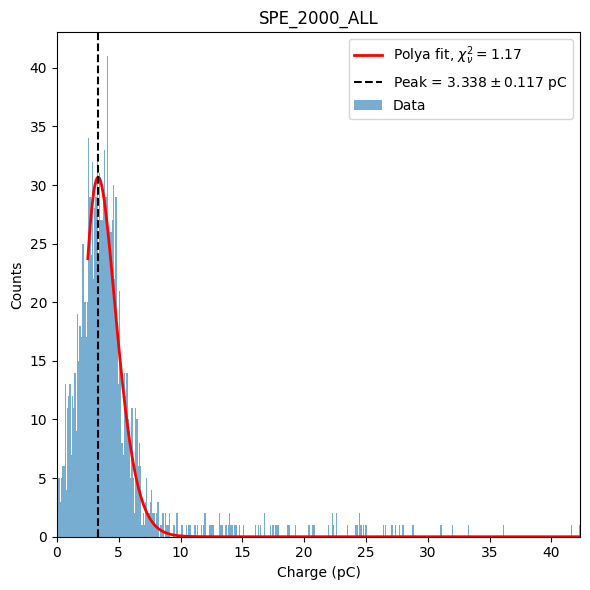

CSV file outputted successfully!


In [52]:
spe_results = []

spe_voltage_data = collect_charge_by_voltage(spe_files)

for voltage in sorted(spe_voltage_data.keys()):
    charge = spe_voltage_data[voltage]

    if voltage == 2000:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=2.5, filename=f"SPE_{voltage}_ALL")
    if voltage == 1950:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=2.0, filename=f"SPE_{voltage}_ALL")
    if voltage == 1900:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=1.1, filename=f"SPE_{voltage}_ALL")
    if voltage == 1850:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.8, filename=f"SPE_{voltage}_ALL")
    if voltage == 1800:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.5, filename=f"SPE_{voltage}_ALL")
    if voltage == 1750:
        peak, peak_err = fit_polya_and_get_peak(charge, bin_cut=0.2, filename=f"SPE_{voltage}_ALL")

    spe_results.append({
        'voltage': voltage,
        'polya_peak_pC': peak,
        'polya_peak_error_pC': peak_err
    })

spe_df = pd.DataFrame(spe_results)
spe_df.sort_values('voltage', inplace=True)
spe_df.to_csv('PMT7_spe_COMBINED_polya_peak_positions_nobincut.csv', index=False)


print('CSV file outputted successfully!')